
## To classify location of damage - front, rear or side.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import json
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('whitegrid')

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2,l1
from keras.models import Sequential, load_model,Model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Input
from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint, History

In [ ]:
def save_bottleneck_features(location):
    datagen = ImageDataGenerator(rescale=1./255)

    model = VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size= batch_size,
                                            class_mode=None,
                                            shuffle=False)
    bottleneck_features_train = model.predict(generator, nb_train_samples)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(validation_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=16,
                                           class_mode=None,
                                           shuffle=False)
    bottleneck_features_validation = model.predict(generator, nb_validation_samples)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [ ]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('epoch:', best_epoch+1, \
    ', val_accuracy:', model_hist['val_accuracy'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

In [ ]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')

    plt.tight_layout();

    print("Best Model:")
    print_best_model_results(hist)

In [ ]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=batch_size,
                                class_mode='categorical',
                                shuffle=False)

    predictions = model.predict(generator, len(labels))
    pred_labels = np.argmax(predictions, axis=1)

    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    sns.heatmap(cm, annot=True);

## Defining Inputs

In [ ]:
# path to the model weights file
location = '/content/drive/MyDrive/data2a'
top_model_weights_path=location+'/top_model_weights' # will be saved into when we create our model
fine_tuned_model_path = location+'/ft_model.hdf5'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)

nb_epoch = 50
batch_size = 8

In [ ]:
# do not rerun!!
save_bottleneck_features(location)

58889256/58889256 [==============================] - 0s 0us/step
Found 829 images belonging to 3 classes.
104/104 [==============================] - 230s 2s/step
Found 171 images belonging to 3 classes.
11/11 [==============================] - 63s 6s/step


In [ ]:
# load saved data and train a small, fully-connected model
def train_categorical_model1():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1] +
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] +
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


    checkpoint = ModelCheckpoint(top_model_weights_path+"_1.hdf5", monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history_1.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d1_model, d1_history = train_categorical_model1()

Epoch 1/50
 93/104 [=========================>....] - ETA: 0s - loss: 2.7342 - accuracy: 0.4435
Epoch 1: val_accuracy improved from -inf to 0.51462, saving model to /content/drive/MyDrive/data2a/top_model_weights_1.hdf5
104/104 [==============================] - 2s 9ms/step - loss: 2.6067 - accuracy: 0.4524 - val_loss: 2.2007 - val_accuracy: 0.5146
Epoch 2/50
 94/104 [==========================>...] - ETA: 0s - loss: 1.1200 - accuracy: 0.6968
Epoch 2: val_accuracy did not improve from 0.51462
104/104 [==============================] - 1s 6ms/step - loss: 1.1866 - accuracy: 0.6948 - val_loss: 2.2055 - val_accuracy: 0.5088
Epoch 3/50
103/104 [============================>.] - ETA: 0s - loss: 0.7098 - accuracy: 0.8119
Epoch 3: val_accuracy improved from 0.51462 to 0.67251, saving model to /content/drive/MyDrive/data2a/top_model_weights_1.hdf5
104/104 [==============================] - 1s 6ms/step - loss: 0.7065 - accuracy: 0.8130 - val_loss: 1.3196 - val_accuracy: 0.6725
Epoch 4/50
 93/10

Best Model:
epoch: 29 , val_accuracy: 0.7251461744308472 , val_loss: 2.160273313522339


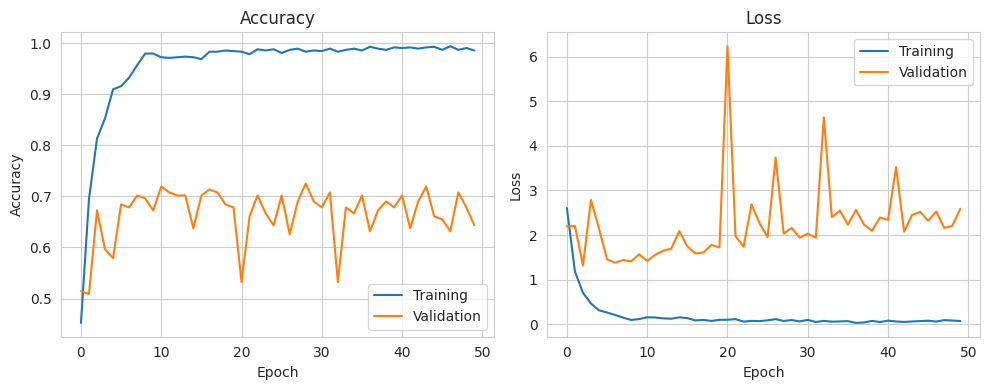

In [ ]:
plot_metrics(d1_history) #rmsprop with no regularization,without dropout

In [ ]:
# load saved data and train a small, fully-connected model
def train_categorical_model2():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1] +
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] +
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax'))


    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


    checkpoint = ModelCheckpoint(top_model_weights_path+"_2.hdf5", monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history_2.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d2_model, d2_history = train_categorical_model2()

Epoch 1/50
101/104 [============================>.] - ETA: 0s - loss: 4.3054 - accuracy: 0.4208
Epoch 1: val_accuracy improved from -inf to 0.40351, saving model to /content/drive/MyDrive/data2a/top_model_weights_2.hdf5
104/104 [==============================] - 2s 8ms/step - loss: 4.2205 - accuracy: 0.4222 - val_loss: 1.0718 - val_accuracy: 0.4035
Epoch 2/50
104/104 [==============================] - ETA: 0s - loss: 1.2829 - accuracy: 0.4994
Epoch 2: val_accuracy improved from 0.40351 to 0.43860, saving model to /content/drive/MyDrive/data2a/top_model_weights_2.hdf5
104/104 [==============================] - 1s 6ms/step - loss: 1.2829 - accuracy: 0.4994 - val_loss: 3.2168 - val_accuracy: 0.4386
Epoch 3/50
102/104 [============================>.] - ETA: 0s - loss: 1.0882 - accuracy: 0.5564
Epoch 3: val_accuracy improved from 0.43860 to 0.61404, saving model to /content/drive/MyDrive/data2a/top_model_weights_2.hdf5
104/104 [==============================] - 1s 6ms/step - loss: 1.0906 - 

Best Model:
epoch: 41 , val_accuracy: 0.7309941649436951 , val_loss: 2.3614578247070312


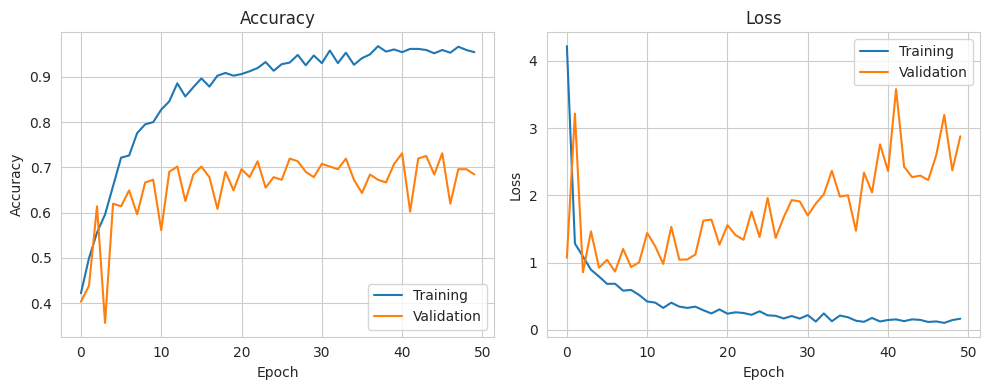

In [ ]:
plot_metrics(d2_history) #rmsprop with dropout

In [ ]:
# load saved data and train a small, fully-connected model
def train_categorical_model3():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1] +
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] +
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


    checkpoint = ModelCheckpoint(top_model_weights_path+"_3.hdf5", monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history_3.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d3_model, d3_history = train_categorical_model3()

Epoch 1/50
101/104 [============================>.] - ETA: 0s - loss: 4.6271 - accuracy: 0.3960
Epoch 1: val_accuracy improved from -inf to 0.49123, saving model to /content/drive/MyDrive/data2a/top_model_weights_3.hdf5
104/104 [==============================] - 2s 11ms/step - loss: 4.5721 - accuracy: 0.3908 - val_loss: 1.3159 - val_accuracy: 0.4912
Epoch 2/50
 97/104 [==========================>...] - ETA: 0s - loss: 1.3196 - accuracy: 0.4407
Epoch 2: val_accuracy did not improve from 0.49123
104/104 [==============================] - 1s 7ms/step - loss: 1.3216 - accuracy: 0.4451 - val_loss: 1.1168 - val_accuracy: 0.3918
Epoch 3/50
 98/104 [===========================>..] - ETA: 0s - loss: 1.1491 - accuracy: 0.4681
Epoch 3: val_accuracy did not improve from 0.49123
104/104 [==============================] - 1s 6ms/step - loss: 1.1498 - accuracy: 0.4656 - val_loss: 1.1582 - val_accuracy: 0.4152
Epoch 4/50
100/104 [===========================>..] - ETA: 0s - loss: 1.0554 - accuracy: 0.5

Best Model:
epoch: 6 , val_accuracy: 0.6725146174430847 , val_loss: 0.9895358681678772


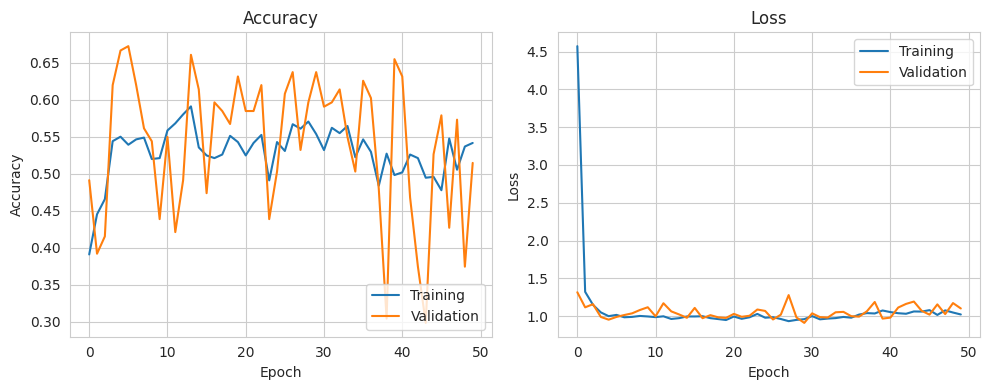

In [ ]:
plot_metrics(d3_history) #rmsprop with dropout and regularization

In [ ]:
# load saved data and train a small, fully-connected model
def train_categorical_model4():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1] +
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] +
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer='l2'))
    model.add(Dropout(0.75))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


    checkpoint = ModelCheckpoint(top_model_weights_path+"_4.hdf5", monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history_4.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d4_model, d4_history = train_categorical_model4()

Epoch 1/50
100/104 [===========================>..] - ETA: 0s - loss: 5.5258 - accuracy: 0.3862
Epoch 1: val_accuracy improved from -inf to 0.32164, saving model to /content/drive/MyDrive/data2a/top_model_weights_4.hdf5
104/104 [==============================] - 1s 8ms/step - loss: 5.3771 - accuracy: 0.3800 - val_loss: 1.2914 - val_accuracy: 0.3216
Epoch 2/50
 99/104 [===========================>..] - ETA: 0s - loss: 1.3651 - accuracy: 0.3497
Epoch 2: val_accuracy did not improve from 0.32164
104/104 [==============================] - 1s 5ms/step - loss: 1.3539 - accuracy: 0.3486 - val_loss: 1.1128 - val_accuracy: 0.2924
Epoch 3/50
102/104 [============================>.] - ETA: 0s - loss: 1.1541 - accuracy: 0.3407
Epoch 3: val_accuracy did not improve from 0.32164
104/104 [==============================] - 1s 5ms/step - loss: 1.1533 - accuracy: 0.3402 - val_loss: 1.1052 - val_accuracy: 0.2924
Epoch 4/50
 95/104 [==========================>...] - ETA: 0s - loss: 1.0997 - accuracy: 0.35

Best Model:
epoch: 1 , val_accuracy: 0.32163742184638977 , val_loss: 1.291386604309082


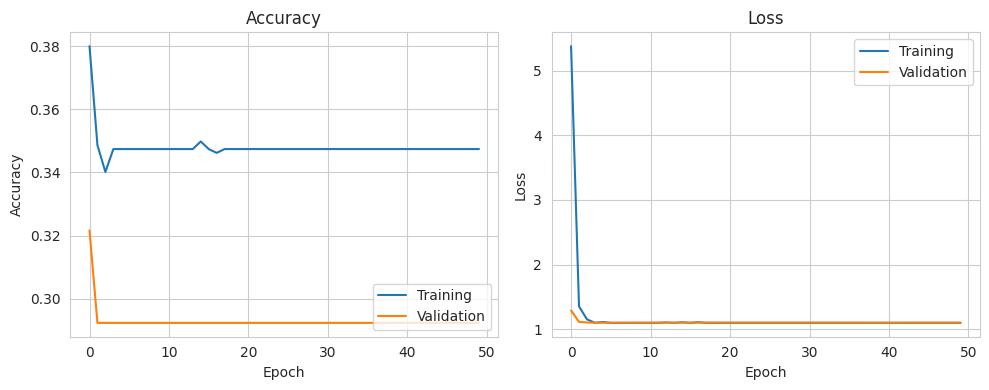

In [ ]:
plot_metrics(d4_history) #rmsprop with aggresive dropout and regularization

In [ ]:
# load saved data and train a small, fully-connected model
def train_categorical_model5():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1] +
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] +
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path+"_5.hdf5", monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history_5.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d5_model, d5_history = train_categorical_model5()

Epoch 1/50
 99/104 [===========================>..] - ETA: 0s - loss: 6.2732 - accuracy: 0.3826
Epoch 1: val_accuracy improved from -inf to 0.45029, saving model to /content/drive/MyDrive/data2a/top_model_weights_5.hdf5
104/104 [==============================] - 1s 8ms/step - loss: 6.2688 - accuracy: 0.3824 - val_loss: 6.1160 - val_accuracy: 0.4503
Epoch 2/50
103/104 [============================>.] - ETA: 0s - loss: 6.1129 - accuracy: 0.4405
Epoch 2: val_accuracy improved from 0.45029 to 0.53216, saving model to /content/drive/MyDrive/data2a/top_model_weights_5.hdf5
104/104 [==============================] - 1s 6ms/step - loss: 6.1142 - accuracy: 0.4391 - val_loss: 6.0721 - val_accuracy: 0.5322
Epoch 3/50
 94/104 [==========================>...] - ETA: 0s - loss: 6.0435 - accuracy: 0.4827
Epoch 3: val_accuracy did not improve from 0.53216
104/104 [==============================] - 1s 5ms/step - loss: 6.0435 - accuracy: 0.4837 - val_loss: 6.0328 - val_accuracy: 0.4678
Epoch 4/50
103/10

Best Model:
epoch: 35 , val_accuracy: 0.6842105388641357 , val_loss: 5.2136335372924805


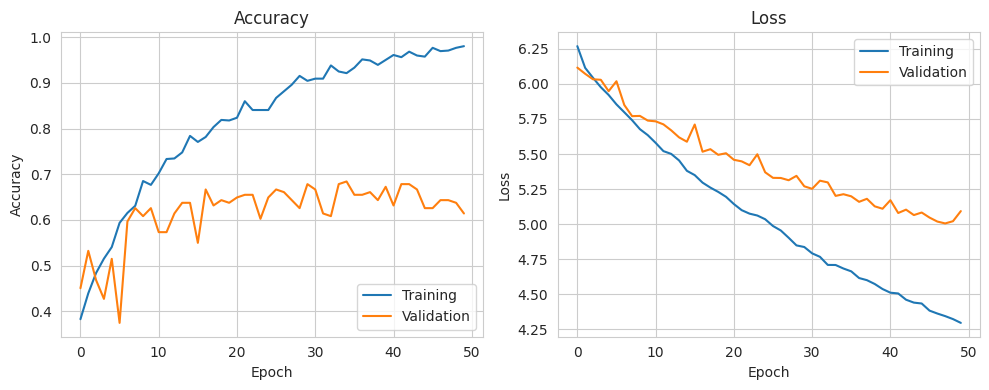

In [ ]:
plot_metrics(d5_history) #sgd with dropout and regularization

In [ ]:
# load saved data and train a small, fully-connected model
def train_categorical_model6():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1] +
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] +
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path+"_6.hdf5", monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history_6.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d6_model, d6_history = train_categorical_model6()

Epoch 1/50
 96/104 [==========================>...] - ETA: 0s - loss: 1.7092 - accuracy: 0.3828
Epoch 1: val_accuracy improved from -inf to 0.40351, saving model to /content/drive/MyDrive/data2a/top_model_weights_6.hdf5
104/104 [==============================] - 1s 8ms/step - loss: 1.6992 - accuracy: 0.3884 - val_loss: 1.5905 - val_accuracy: 0.4035
Epoch 2/50
104/104 [==============================] - ETA: 0s - loss: 1.5288 - accuracy: 0.4608
Epoch 2: val_accuracy improved from 0.40351 to 0.56140, saving model to /content/drive/MyDrive/data2a/top_model_weights_6.hdf5
104/104 [==============================] - 1s 7ms/step - loss: 1.5288 - accuracy: 0.4608 - val_loss: 1.4654 - val_accuracy: 0.5614
Epoch 3/50
 98/104 [===========================>..] - ETA: 0s - loss: 1.4765 - accuracy: 0.5485
Epoch 3: val_accuracy improved from 0.56140 to 0.60234, saving model to /content/drive/MyDrive/data2a/top_model_weights_6.hdf5
104/104 [==============================] - 1s 7ms/step - loss: 1.4746 - 

Best Model:
epoch: 25 , val_accuracy: 0.7017543911933899 , val_loss: 1.249497413635254


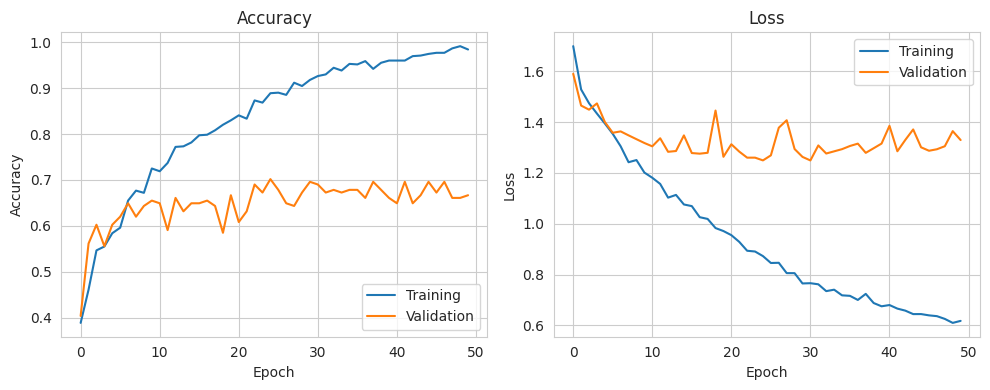

In [ ]:
plot_metrics(d6_history) #sgd with dropout and aggresive regularization

In [ ]:
# load saved data and train a small, fully-connected model
def train_categorical_model7():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1] +
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] +
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.75))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])


    checkpoint = ModelCheckpoint(top_model_weights_path+"_7.hdf5", monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history_7.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d7_model, d7_history = train_categorical_model7()

Epoch 1/50
 98/104 [===========================>..] - ETA: 0s - loss: 1.8732 - accuracy: 0.3469
Epoch 1: val_accuracy improved from -inf to 0.32749, saving model to /content/drive/MyDrive/data2a/top_model_weights_7.hdf5
104/104 [==============================] - 1s 8ms/step - loss: 1.8663 - accuracy: 0.3402 - val_loss: 1.6374 - val_accuracy: 0.3275
Epoch 2/50
102/104 [============================>.] - ETA: 0s - loss: 1.5956 - accuracy: 0.3995
Epoch 2: val_accuracy improved from 0.32749 to 0.47953, saving model to /content/drive/MyDrive/data2a/top_model_weights_7.hdf5
104/104 [==============================] - 1s 6ms/step - loss: 1.5962 - accuracy: 0.3969 - val_loss: 1.5728 - val_accuracy: 0.4795
Epoch 3/50
 99/104 [===========================>..] - ETA: 0s - loss: 1.5928 - accuracy: 0.3763
Epoch 3: val_accuracy did not improve from 0.47953
104/104 [==============================] - 1s 5ms/step - loss: 1.5945 - accuracy: 0.3715 - val_loss: 1.5605 - val_accuracy: 0.4444
Epoch 4/50
101/10

Best Model:
epoch: 50 , val_accuracy: 0.6959064602851868 , val_loss: 1.2671053409576416


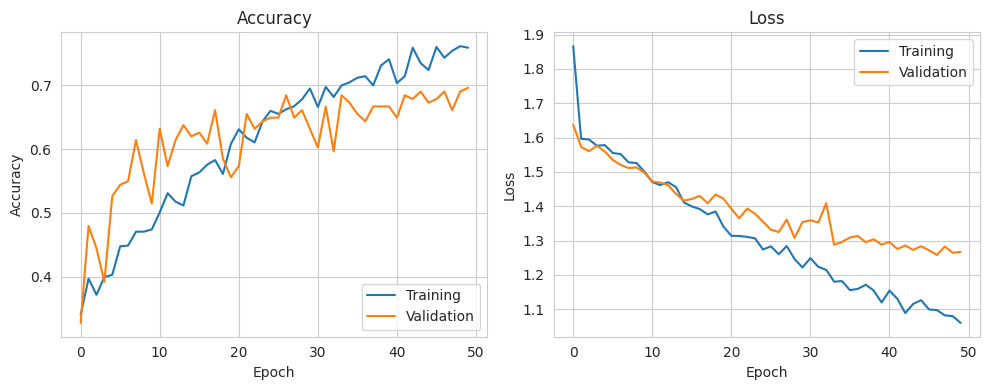

In [ ]:
plot_metrics(d7_history) #sgd with dropout and aggresive regularization

In [ ]:
# load saved data and train a small, fully-connected model
def train_categorical_model8():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1] +
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] +
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(128, activation = 'relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.75))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])


    checkpoint = ModelCheckpoint(top_model_weights_path+"_8.hdf5", monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history_8.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d8_model, d8_history = train_categorical_model8()

Epoch 1/50
 94/104 [==========================>...] - ETA: 0s - loss: 1.9122 - accuracy: 0.3364
Epoch 1: val_accuracy improved from -inf to 0.42105, saving model to /content/drive/MyDrive/data2a/top_model_weights_8.hdf5
104/104 [==============================] - 2s 9ms/step - loss: 1.9121 - accuracy: 0.3257 - val_loss: 1.7460 - val_accuracy: 0.4211
Epoch 2/50
 98/104 [===========================>..] - ETA: 0s - loss: 1.8215 - accuracy: 0.3559
Epoch 2: val_accuracy did not improve from 0.42105
104/104 [==============================] - 1s 8ms/step - loss: 1.8161 - accuracy: 0.3667 - val_loss: 1.7815 - val_accuracy: 0.3392
Epoch 3/50
100/104 [===========================>..] - ETA: 0s - loss: 1.7888 - accuracy: 0.3675
Epoch 3: val_accuracy improved from 0.42105 to 0.54386, saving model to /content/drive/MyDrive/data2a/top_model_weights_8.hdf5
104/104 [==============================] - 1s 9ms/step - loss: 1.7866 - accuracy: 0.3703 - val_loss: 1.7350 - val_accuracy: 0.5439
Epoch 4/50
 97/10

Best Model:
epoch: 41 , val_accuracy: 0.7251461744308472 , val_loss: 1.5007270574569702


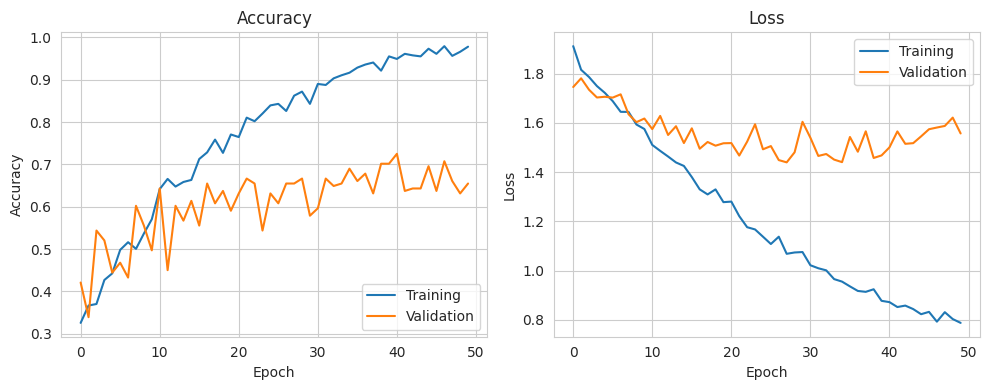

In [ ]:
plot_metrics(d8_history) #sgd with dropout and aggresive regularization with additional dense layer

In [ ]:
# load saved data and train a small, fully-connected model
def train_categorical_model9():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] +
                            [1] * train_samples[1] +
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] +
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation = 'relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.75))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])


    checkpoint = ModelCheckpoint(top_model_weights_path+"_9.hdf5", monitor='val_accuracy',
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])

    with open(location+'/top_history_9.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
d9_model, d9_history = train_categorical_model9()

Epoch 1/50
 95/104 [==========================>...] - ETA: 0s - loss: 2.1253 - accuracy: 0.3500
Epoch 1: val_accuracy improved from -inf to 0.29240, saving model to /content/drive/MyDrive/data2a/top_model_weights_9.hdf5
104/104 [==============================] - 2s 9ms/step - loss: 2.0985 - accuracy: 0.3486 - val_loss: 1.7773 - val_accuracy: 0.2924
Epoch 2/50
102/104 [============================>.] - ETA: 0s - loss: 1.7937 - accuracy: 0.3333
Epoch 2: val_accuracy improved from 0.29240 to 0.49123, saving model to /content/drive/MyDrive/data2a/top_model_weights_9.hdf5
104/104 [==============================] - 1s 7ms/step - loss: 1.7933 - accuracy: 0.3353 - val_loss: 1.7679 - val_accuracy: 0.4912
Epoch 3/50
100/104 [===========================>..] - ETA: 0s - loss: 1.7778 - accuracy: 0.3262
Epoch 3: val_accuracy did not improve from 0.49123
104/104 [==============================] - 1s 6ms/step - loss: 1.7779 - accuracy: 0.3269 - val_loss: 1.7848 - val_accuracy: 0.2690
Epoch 4/50
 96/10

Best Model:
epoch: 2 , val_accuracy: 0.4912280738353729 , val_loss: 1.7679111957550049


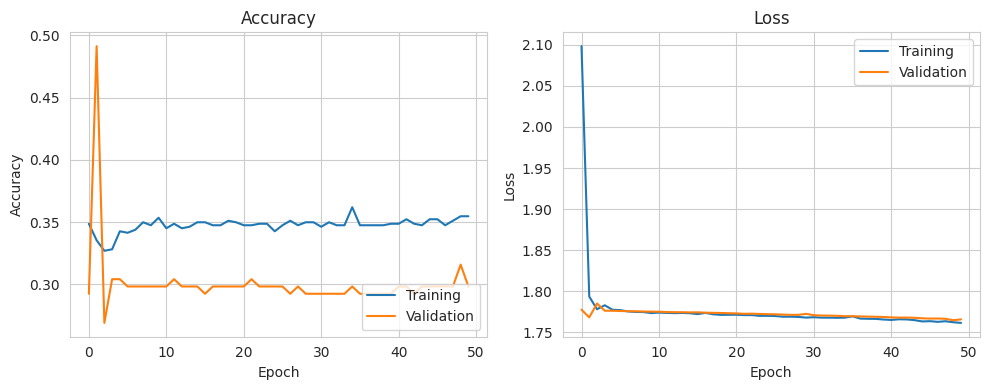

In [ ]:
plot_metrics(d9_history) #sgd with dropout and aggresive regularization with additional dense layer

In [ ]:
def finetune_categorical_model():
    # Build the VGG16 Network (again)
    input_tensor = Input(shape=(256,256,3))
    base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    top_model.load_weights(top_model_weights_path+"_2.hdf5")

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    for layer in model.layers[:15]:
        layer.trainable=False


    model.compile(loss='categorical_crossentropy',
                 optimizer = optimizers.SGD(learning_rate=0.00001, momentum=0.9),
                  metrics=['accuracy'])

    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=8,
                                                     class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=8,
                                                           class_mode='categorical')


    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy',
                                 verbose=2, save_best_only=True,
                                 save_weights_only=False, mode='max')
    # fine-tune the model
    fit = model.fit(train_generator,
                    steps_per_epoch=nb_train_samples//batch_size,
                        epochs=nb_epoch,
                        validation_data=validation_generator,
                         validation_steps=nb_validation_samples//batch_size,
                        verbose=1,
                        callbacks=[checkpoint])

    with open(location+'/history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
ft_model, ft_history = finetune_categorical_model()

Found 829 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 21.6053 - accuracy: 0.6029
Epoch 1: val_accuracy improved from -inf to 0.72619, saving model to /content/drive/MyDrive/data2a/ft_model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


103/103 [==============================] - 23s 217ms/step - loss: 21.6053 - accuracy: 0.6029 - val_loss: 21.5361 - val_accuracy: 0.7262
Epoch 2/50
103/103 [==============================] - ETA: 0s - loss: 22.0097 - accuracy: 0.5932
Epoch 2: val_accuracy improved from 0.72619 to 0.73810, saving model to /content/drive/MyDrive/data2a/ft_model.hdf5
103/103 [==============================] - 24s 228ms/step - loss: 22.0097 - accuracy: 0.5932 - val_loss: 21.4365 - val_accuracy: 0.7381
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 21.9359 - accuracy: 0.5944
Epoch 3: val_accuracy did not improve from 0.73810
103/103 [==============================] - 22s 218ms/step - loss: 21.9359 - accuracy: 0.5944 - val_loss: 21.5353 - val_accuracy: 0.7262
Epoch 4/50
103/103 [==============================] - ETA: 0s - loss: 22.0692 - accuracy: 0.5798
Epoch 4: val_accuracy did not improve from 0.73810
103/103 [==============================] - 21s 205ms/step - loss: 22.0692 - accurac

Best Model:
epoch: 2 , val_accuracy: 0.738095223903656 , val_loss: 21.436450958251953


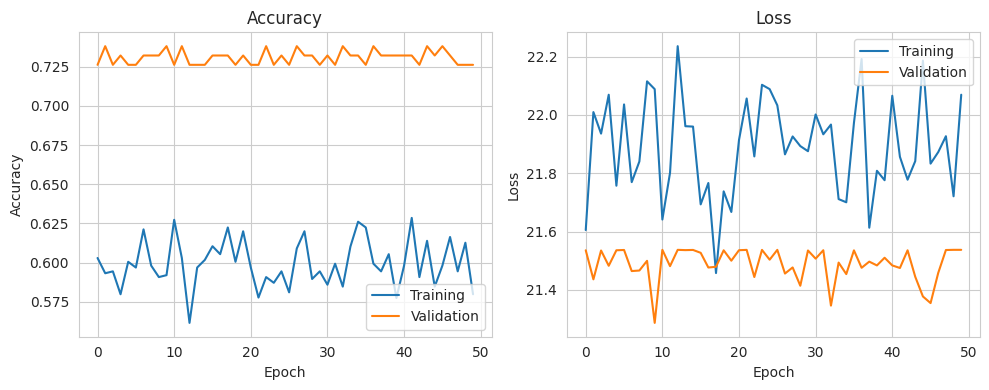

In [ ]:
plot_metrics(ft_history)

##Load Model Point

In [ ]:
ft_model = load_model(location+'/ft_model.hdf5')

In [ ]:
with open(location+'/top_history_2.txt') as f:
    top_history = json.load(f)

In [ ]:
with open(location+'/history.txt') as f:
    ft_history = json.load(f)

In [ ]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')

    plt.tight_layout();

    print("Best Model:")
    print_best_model_results(hist)

In [ ]:
def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))

    axes = axes.flatten()

    axes[0].plot(range(stop), hist1['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist2['accuracy'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_accuracy'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')

    plt.tight_layout();

In [ ]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=batch_size,
                                class_mode='categorical',
                                shuffle=False)

    predictions = model.predict(generator, len(labels))
    pred_labels = np.argmax(predictions, axis=1)

    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

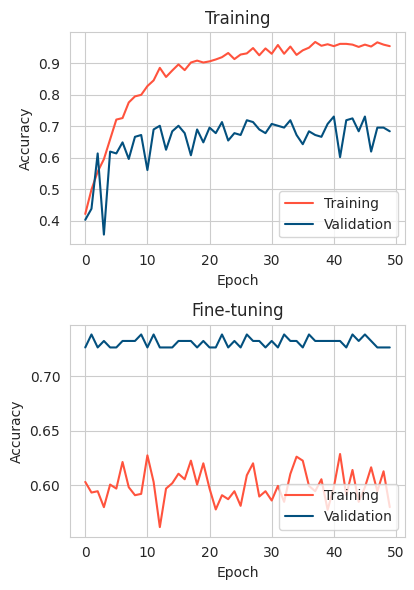

In [ ]:
plot_acc_metrics(top_history, ft_history)

Best Model:
epoch: 2 , val_accuracy: 0.738095223903656 , val_loss: 21.436450958251953


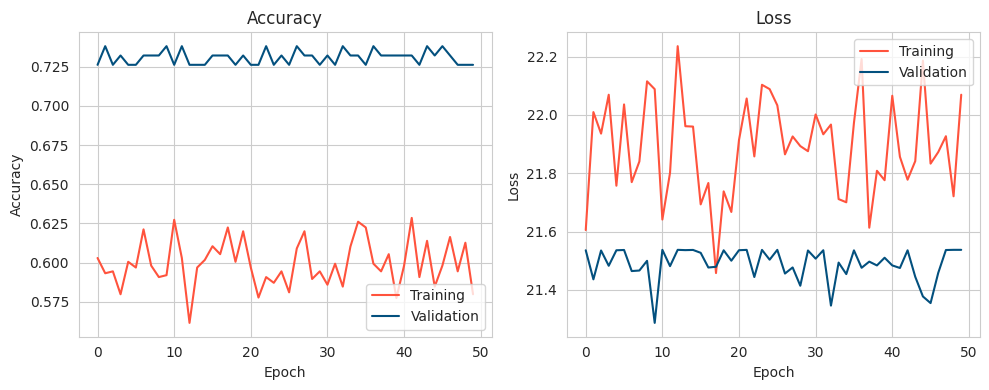

In [ ]:
# Best Model
plot_metrics(ft_history) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

In [ ]:
validation_labels = np.array([0] * validation_samples[0] +
                             [1] * validation_samples[1]+
                             [2] * validation_samples[2])

In [ ]:
cm = evaluate_categorical_model(ft_model, validation_data_dir, validation_labels)

Found 171 images belonging to 3 classes.
22/22 [==============================] - 3s 138ms/step

              precision    recall  f1-score   support

           0       0.78      0.79      0.79        73
           1       0.62      0.68      0.65        50
           2       0.79      0.69      0.73        48

    accuracy                           0.73       171
   macro avg       0.73      0.72      0.72       171
weighted avg       0.74      0.73      0.73       171




In [ ]:
heatmap_labels = ['Front', 'Rear', 'Side']

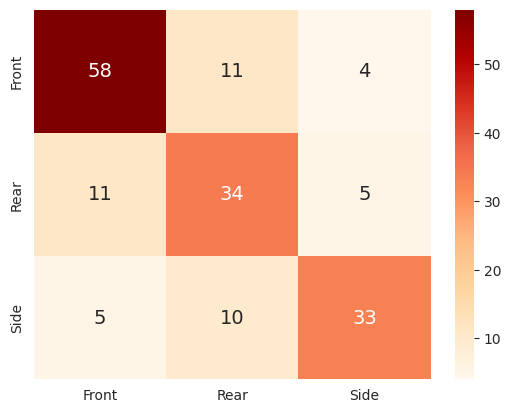

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 14},
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

## Making Live Predictions

In [ ]:
from urllib.request import urlretrieve

def car_categories_gate(image_path, model,option=1):
    if(option==1):
      urlretrieve(image_path, 'save.jpg')
      img = load_img('save.jpg', target_size=(256, 256))
    else:
      img = load_img(image_path, target_size=(256, 256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)/255
    pred = model.predict(x)
    print(pred)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'Front', 1:'Rear', 2:'Side'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Validating location of damage....Result:",d[key])
    print("Severity assessment complete.")

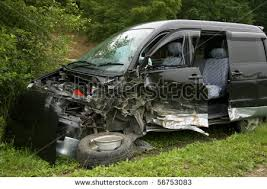

In [ ]:
Image(location+"/validation/00-front/0001.JPEG")

In [ ]:
car_categories_gate(location+"/validation/00-front/0001.JPEG", ft_model,0)

1/1 [==============================] - 1s 1s/step
[[1.0000000e+00 3.5491327e-10 1.0742587e-18]]
Validating location of damage....Result: Front
Severity assessment complete.


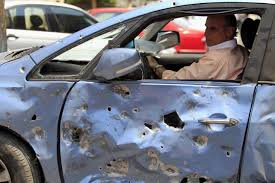

In [ ]:
Image('/content/drive/MyDrive/data1a/validation/00-damage/0010.JPEG')

In [ ]:
car_categories_gate('/content/drive/MyDrive/data1a/validation/00-damage/0010.JPEG', ft_model,0)

1/1 [==============================] - 0s 133ms/step
[[8.575964e-16 6.770031e-16 1.000000e+00]]
Validating location of damage....Result: Side
Severity assessment complete.


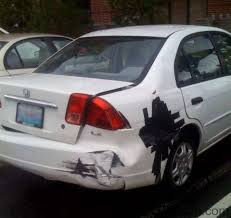

In [ ]:
Image(location+"/validation/01-rear/0002.JPEG")

In [ ]:
car_categories_gate(location+"/validation/01-rear/0002.JPEG", ft_model,0)

1/1 [==============================] - 0s 18ms/step
[[2.2681795e-02 9.7731668e-01 1.4626135e-06]]
Validating location of damage....Result: Rear
Severity assessment complete.


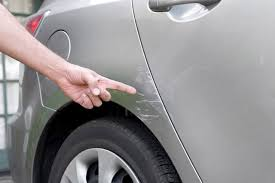

In [ ]:
Image(location+"/validation/02-side/0004.JPEG")

In [ ]:
car_categories_gate(location+"/validation/02-side/0004.JPEG", ft_model,0)

1/1 [==============================] - 0s 17ms/step
[[1.03924845e-04 1.01022840e-06 9.99895096e-01]]
Validating location of damage....Result: Side
Severity assessment complete.


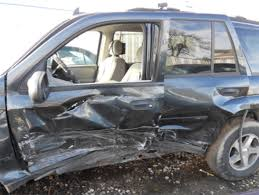

In [ ]:
Image(location+"/validation/02-side/0005.JPEG")

In [ ]:
car_categories_gate(location+"/validation/02-side/0005.JPEG", ft_model,0)

1/1 [==============================] - 0s 25ms/step
[[7.2834206e-05 1.4658853e-04 9.9978060e-01]]
Validating location of damage....Result: Side
Severity assessment complete.


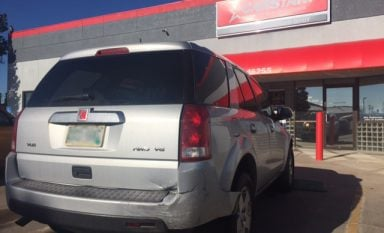

In [ ]:
Image('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg')

In [ ]:
car_categories_gate('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg', ft_model)

1/1 [==============================] - 0s 18ms/step
[[6.0192044e-05 9.9992895e-01 1.0889225e-05]]
Validating location of damage....Result: Rear
Severity assessment complete.
